In [2]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)


In [19]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from imblearn.over_sampling import RandomOverSampler


### Loading the Data

In [20]:
cvd_data = pd.read_csv(r"Datasets\Analyzed\Analyzed_CVD_Prediction.csv")
cvd_data.head()

,heart_rate,oxygen_saturation,respiratory_rate,temperature,Label
0,90.0,95.0,18.0,36.9,0
1,87.0,96.0,13.0,37.5,0
2,96.0,97.0,18.0,37.0,0
3,76.0,97.0,22.0,37.9,1
4,95.0,95.0,16.0,37.8,0


In [21]:
cvd_data['Label'].value_counts()

Label
0    2089
1    2089
Name: count, dtype: int64

# Training a DL Model using Keras with 2 Layers

In [23]:
# Split the data into training and validation sets
train_data = cvd_data.sample(frac=0.8, random_state=0)
val_data = cvd_data.drop(train_data.index)

# Preprocess the data
train_labels = train_data.pop('Label')
val_labels = val_data.pop('Label')

# Convert labels to numpy array if not already
train_labels_np = np.array(train_labels)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, train_labels, epochs=50,
                    validation_data=(val_data, val_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(val_data, val_labels)

print('Test accuracy:', test_acc)


Epoch 1/50
105/105 [==============================] - 1s 5ms/step - loss: 0.4044 - accuracy: 0.8462 - val_loss: 0.3202 - val_accuracy: 0.9091
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 0.3038 - accuracy: 0.9180 - val_loss: 0.3486 - val_accuracy: 0.8744
Epoch 3/50
105/105 [==============================] - 0s 4ms/step - loss: 0.2943 - accuracy: 0.9060 - val_loss: 0.2741 - val_accuracy: 0.9115
Epoch 4/50
105/105 [==============================] - 0s 3ms/step - loss: 0.2616 - accuracy: 0.9177 - val_loss: 0.2850 - val_accuracy: 0.8923
Epoch 5/50
105/105 [==============================] - 0s 2ms/step - loss: 0.2433 - accuracy: 0.9252 - val_loss: 0.2233 - val_accuracy: 0.9378
Epoch 6/50
105/105 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.9282 - val_loss: 0.2110 - val_accuracy: 0.9366
Epoch 7/50
105/105 [==============================] - 0s 2ms/step - loss: 0.2194 - accuracy: 0.9363 - val_loss: 0.2552 - val_accuracy: 0.9151
Epoch 

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

preds = (model.predict(val_data) > 0.5).astype(int)
print(confusion_matrix(val_labels, preds))
print(classification_report(val_labels, preds))

27/27 [==============================] - 0s 1ms/step
[[416   0]
 [ 48 372]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       416
           1       1.00      0.89      0.94       420

    accuracy                           0.94       836
   macro avg       0.95      0.94      0.94       836
weighted avg       0.95      0.94      0.94       836



In [25]:
N = 100
random_samples = val_data.sample(n=N, random_state=42)

# Get the model's predictions
predictions = model.predict(random_samples)

# Convert sigmoid output (0–1) to class (0 or 1)
predicted_classes = (predictions > 0.5).astype("int32")

# Show results nicely
for i in range(N):
    print(f"\nSample {i+1}:")
    print(random_samples.iloc[i])
    print(f"Predicted Probability: {predictions[i][0]:.4f}")
    print(f"Predicted Class: {predicted_classes[i][0]}")


4/4 [==============================] - 0s 2ms/step

Sample 1:
heart_rate           98.0
oxygen_saturation    96.0
respiratory_rate     16.0
temperature          37.1
Name: 2997, dtype: float64
Predicted Probability: 0.0826
Predicted Class: 0

Sample 2:
heart_rate           75.0
oxygen_saturation    99.0
respiratory_rate     37.0
temperature          36.3
Name: 4115, dtype: float64
Predicted Probability: 1.0000
Predicted Class: 1

Sample 3:
heart_rate           91.0
oxygen_saturation    96.0
respiratory_rate     24.0
temperature          37.5
Name: 1429, dtype: float64
Predicted Probability: 1.0000
Predicted Class: 1

Sample 4:
heart_rate           92.0
oxygen_saturation    99.0
respiratory_rate     16.0
temperature          37.3
Name: 4016, dtype: float64
Predicted Probability: 0.0545
Predicted Class: 0

Sample 5:
heart_rate           92.0
oxygen_saturation    95.0
respiratory_rate     16.0
temperature          37.7
Name: 854, dtype: float64
Predicted Probability: 0.1008
Predicted Clas

27/27 [==============================] - 0s 2ms/step


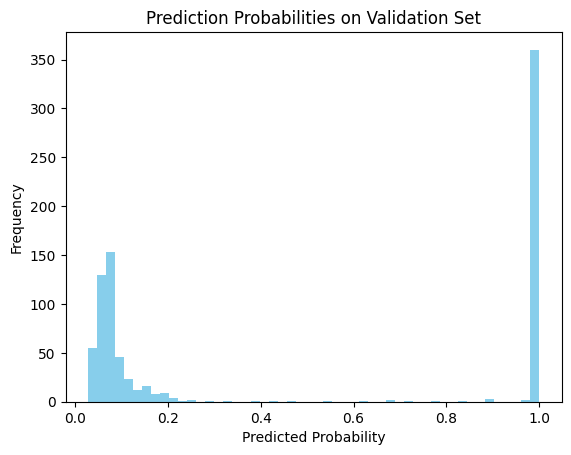

In [26]:

probs = model.predict(val_data)
plt.hist(probs, bins=50, color='skyblue')
plt.title("Prediction Probabilities on Validation Set")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

#### These scores seems good to be deploy, so it will be converted into a TFLite model

### Converting this model to TFLite Model

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]  # <-- ensure Pi compatibility
tflite_model = converter.convert()

with open('Models/CVD_Classification_Model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\SANDIN~1\AppData\Local\Temp\tmpvrc1l299\assets
